<h1 id="tocheading">TransferWise - Take Home Test (Part B)</h1>
<div id="toc"></div>

## Purpose
The purpose of Part B is to get a sense of your understanding of A/B testing, its core components and challenges that may arise along the way. It is not expected that you provide extensive calculations or proofs of statistical concepts, we are mostly interested in seeing how you approach the problem. 


## Background

The referral team is part of the customer journey tribe, and handles our referral product where users get a free transfer if a friend invites them. We’d like to run an A/B test to improve conversion rate for people who are invited to TransferWise. The new variant we want to test also includes a time limit on the free transfer which is 14 days from the day that you click the invite link, see below: 

<img src="data/ab.png">

With this new feature we hope to increase the 10-day conversion rate from clicking the invite link to sending money with us, by introducing a deadline for when they no longer qualify for their free transfer. Current 10-day conversion rate from clicking an invite link is 8.9%, and we’d look to improve this to at least 9.35%.

## Questions

### How big a sample size would we need for each variant to run this A/B test, assuming we’re running a 50/50 split? How did you come to this number? 
<br>
The sample size calculations are impacted by the significance level, power, and minimum detectable effect. We can use any three of them to calculate the fourth unknown one. So, if we already know that we have a small sample size, then evaluate the other three factors: significance level, power, and minimum detectable effect. In this case, however, we have the current conversion, the desired conversion but the statistical power and significance levels were not informed and will be assumed as: <br><br>
- power (β) = 0.8 <br>
- significance level (⍺) = 0.05

Currently, there are several ways to find the minimum sample size for a A/B test. The statistical formula is little bit complicated, despite the parameters being so straight-forward, so, because of that, the easiest way is to find one of those online calculators, such as:

* https://www.optimizely.com/sample-size-calculator/
* https://www.abtasty.com/sample-size-calculator/

In these ones, the suggested sample size was between 65000 and 70000. To be more precise I decided to code the calculator below and a fun way to plot the sample sizes according to the desired conversion rate (also, power and significance).

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, zscore
import seaborn as sns


def min_sample_size(p1, p2, power=0.8, sig=0.05):
    '''
    This formula below assumes equal-sized groups:
    p1: Baseline conversion expected from control group
    p2: Desirable conversion expected from experiment group
    power: Statistical power
    sig: Significance level
    '''
    z = norm.isf([sig/2]) #two-sided t test
    zp = -1 * norm.isf([power]) 
    d = (p1-p2)
    s =2*((p1+p2) /2)*(1-((p1+p2) /2))
    n = s * ((zp + z)**2) / (d**2)
    return float_to_int(round(n[0]))


def float_to_int(x):
    if x == float('inf') or x == float('-inf'):
        return float('nan') # or a large value you choose
    return int(x)


def plot_min_sample_sizes(baseline_conversion_rate, desirable_conversion_rate, power, sig):
    sample_sizes = []
    new_cr = []
    for i in np.arange(baseline_conversion_rate, baseline_conversion_rate*2, 0.0001):
        sample_size = min_sample_size(baseline_conversion_rate, i, power, sig)
        sample_sizes.append(sample_size)
        new_cr.append(i)

    sns.set(rc={'figure.figsize':(13, 7)})
    target_mss = min_sample_size(baseline_conversion_rate, desirable_conversion_rate, power=power, sig=sig)
    ax = sns.lineplot(x=new_cr, y=sample_sizes);
    ax.text(desirable_conversion_rate, 
            target_mss,
            "{}% conversion - {} samples".format(desirable_conversion_rate*100, target_mss),
            color='k');
    ax.set_title("Minimum Samples necessary for the desirable conversion rate");
    ax.set_xlabel("Desirable Conversion Rate");
    ax.set_ylabel("Minimum Sample Size");
    ax.set_xlim([0.0899, 0.14]);
    ax.set_ylim([200, 130000]);
    plt.axvline(desirable_conversion_rate, 0, target_mss/130000, color='r', linestyle='--');


### If you want to mess around this calculator, change some of the parameters below

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide


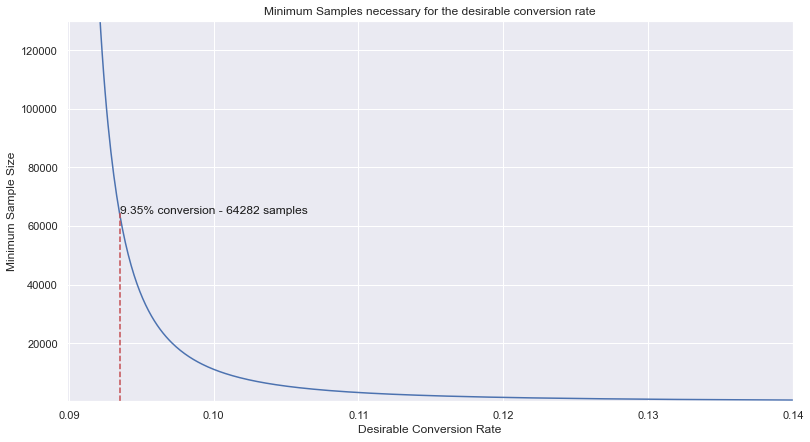

In [30]:
baseline_conversion_rate = 0.089
desirable_conversion_rate = 0.0935
power = 0.8
significance = 0.05
 
plot_min_sample_sizes(baseline_conversion_rate, desirable_conversion_rate, power, significance)

Although the method above gives 64282 samples as the minimum number, it would be a lot safer to get around 70,000 samples if, of course, there are huge numbers of samples available for the test.

### Are there any unintended consequences of making this change that you can foresee?

I believe that one of the possible pitfalls might be that, by putting a deadline, you will have more people utilizing the discount instead of them waiting a very long time for the right opportunity. If that's the case, then it could generate a lot more costs on customer acquisition on a low retention. 

### Generally when running A/B tests, we use an ⍺ of 0.05, but when would you be OK with having an ⍺ of 0.1 instead? When would you want to lower it to e.g. 0.025? 

Given that the *statistical power* is the probability of detecting that difference between the original rate and the variant conversion rates, by increasing the confidence level to 0.1 you are also gaining some power on the test. Of course that, by doing that, you will also allow for a greater probability of false positives. It could be ok when you have a very limited sample size. 
<br>
Confidence levels are about how much are you willing to take a risk. If there are enough samples, high variance and you want to be as accurate as possible, you could try and lower to 0.025 or even 0.01. If I make a confidence interval narrower with lower variability and higher sample size it becomes more precise, the likely values cover a smaller range. If I increase the coverage by using a 99% calculation it becomes more accurate, the true value is more likely to be within the range.

###  Similarly, power is usually set to 80% for A/B tests, but this is not a hard rule. When would you be OK with 50% power instead? Are there any cases where you’d want to have a power > 80%?

With 80% power, there's a 20% probability of not being able to detect an actual difference for a given magnitude of interest. So when the power is set to 50%, you have the same probability of **not** being able to detect actual differences and then your test would be very questionable.
<br><br>
If you have a large sample size, it would be ok to raise the statistical power, but each increase in power requires a corresponding increase in the sample size and the amount of time the test needs to run (time you could waste running a losing test—and losing sales—solely for an extra percentage point or two of statistical probability).

### A common problem with A/B testing is a lack of data, or at least a lack of data within an acceptable time window, which makes it hard to run a test until it reaches significance and power. What would you do if the sample size required for an A/B test is too large to be feasible?

Generally, if you have a very small sample size, you could try:
<br>
* Increase the ⍺ to 0.1 or maybe even 0.2 <br>
* Increase the duration of the test. If you can afford to keep the test going for longer periods of time, eventually you will be able to observe statistical difference.
* Test on scenarios with a higher baseline conversion rate, since the observable effects might be easier to spot than on very low conversion rates, for instance <br>
* Utilize other success metrics, in order to learn more from the user's behaviour, rather than focusing on the lift. <br>
* Don't bet on A/B tests. Despite the great statistical validity that A/B tests provide, if you don't have users enough to make the test feasible, try short sequential tests, because splitting your base might just affect your variance.

In [4]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>